# NARMA10 task with Echo State Networks

This task consists in predicting the output of a 10-th order non-linear autoregressive moving average (NARMA) system.
- [Reference paper](https://doi.org/10.1016/j.neunet.2011.02.002)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import itertools

# from gridsearch import GS

The input of the system is a sequence of elements 𝑥(𝑡) randomly chosen according to a uniform distribution over [0, 0.5]. 

Given the input value 𝑥(𝑡), the task is to predict the corresponding value of 𝑦(𝑡).

- Import the dataset from the .csv file *NARMA10.csv*, where the first row represents the input and the second row represents the
target output. Different columns represent different time-steps.
- Split the data into training (the first 5000 time steps), and test set (remaining time steps). Note that for model selection you will use the data in the training set, with a further split in training (first 4000 samples) and validation (last 1000 samples).
    - For the sake of problem understanding, you can try to first visualize the timeseries data

In [2]:
dset = pd.read_csv('../data/NARMA10.csv', header=None).to_numpy()
x = dset[0]
y = dset[1]
x_test = x[:5000]
train = x[5000:] 

x_train = train[:4000]
x_val = train[4000:]

y_test = y[:5000]
train_y = y[5000:] 

y_train = train_y[:4000]
y_val = train_y[4000:]

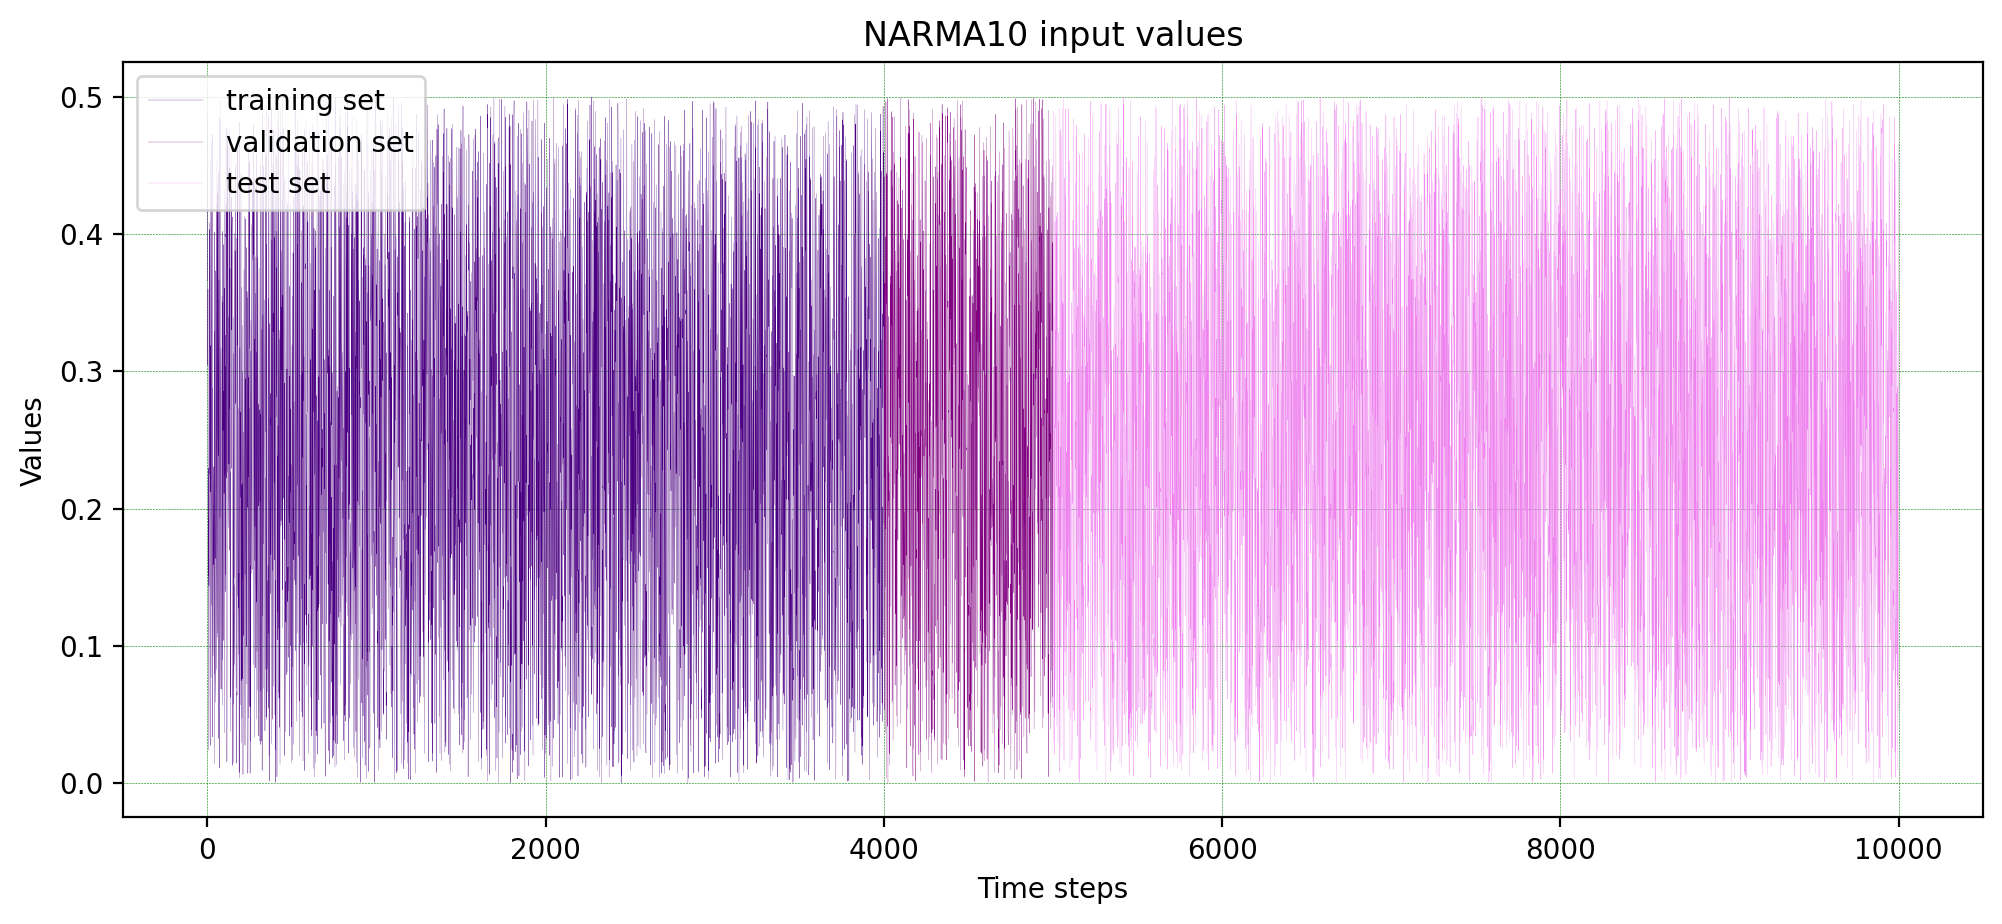

In [3]:
# plot_ts(x_train,x_val,x_test, "NARMA10 input values")

limit1=int(x_train.shape[0])
limit2=int(x_train.shape[0]+x_val.shape[0])
limit3=int(limit2+x_test.shape[0])

plt.figure(figsize=(12,5), dpi=200)
plt.plot(range(0,limit1), x_train, color="indigo", linewidth=0.1, label="training set") 
plt.plot(range(limit1,limit2), x_val, color="purple", linewidth=0.1, label="validation set") 
plt.plot(range(limit2,limit3), x_test, color="violet", linewidth=0.1, label="test set") 

plt.title('NARMA10 input values')
plt.xlabel("Time steps")
plt.ylabel("Values")
plt.legend()
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2)
#plt.savefig(str('plots/timeseries.jpeg'), edgecolor='black', dpi=400, transparent=True)
plt.show()

Implement from scratch the code required to initialize, run, train, and evaluate an **Echo State Network**. Your implementation should take into
consideration relevant hyper-parametrization of the neural network (e.g., number of reservoir neurons, spectral radius, etc.)

## Echo State Network

In [4]:
'''
This code defines a class called `ESN` which stands for Echo State Network. 
An Echo State Network is a type of recurrent neural network known for its simplicity and effectiveness in time-series prediction tasks.
'''
class ESN:
    def __init__(self, input_dim, reservoir_dim, output_dim, omega=0.5, sr=0.95, sparsity=0.1, noise=0.001):
        # self.input_dim = input_dim
        self.reservoir_dim = reservoir_dim
        self.output_dim = output_dim
        # self.sr = sr
        self.sparsity = sparsity
        self.noise = noise

        # weight initialization
        self.W_in = np.random.rand(reservoir_dim, ) * 2 - 1
        self.W_res = np.random.rand(reservoir_dim, reservoir_dim) - omega #Choose the values of W from a random distribution scaled by a hyper-parameter ω
        
        # spectral radius (ro) condition
        radius = np.max(np.abs(np.linalg.eigvals(self.W_res)))
        self.W_res *= sr / radius

        # apply sparsity
        mask = np.random.rand(reservoir_dim, reservoir_dim) > self.sparsity
        self.W_res[mask] = 0

        self.state = np.zeros(reservoir_dim)
        
    def _update_state(self, input_vector):
        # print('input: ', input_vector.shape,'state: ', self.state.shape)
        # print(self.W_in.shape)
        pre_activation = np.dot(self.W_in, input_vector) + np.dot(self.W_res, self.state) #!!!!!! ValueError: 
                                                                    #operands could not be broadcast together with shapes (10,4000) (10,) 
        # pre_activation = [np.dot(self.W_in, input_vector) + np.dot(self.W_res, self.state)] #!!!!!! ValueError: 

        self.state = np.tanh(pre_activation + self.noise * (np.random.rand(self.reservoir_dim) - 0.5))
        return self.state
    
    def fit(self, inputs, targets):
        states = []
        
        for input_vector in inputs:
            # print(inputs.shape, input_vector)

            states.append(self._update_state(input_vector))
        
        states = np.vstack(states)
        
        # Add bias term
        # states = np.hstack((states, np.ones((states.shape[0], 1))))
        
        # Ridge regression (Tikhonov regularization)
        reg = 1e-8
        self.W_out = np.dot(np.dot(targets.T, states), np.linalg.inv(np.dot(states.T, states) + reg * np.eye(states.shape[1]))).T
        
    def predict(self, inputs):
        states = []
        
        for input_vector in inputs:
            states.append(self._update_state(input_vector))
            
        states = np.vstack(states)
        
        # Add bias term
        # states = np.hstack((states, np.ones((states.shape[0], 1))))
        
        return np.dot(states, self.W_out)


In [5]:
# esn = ESN(1, 10, 1)
# esn_fitting = esn.fit(x_train, y_train)

In [6]:

###############################################################################
# # first test the nn then resume this complex grid
###############################################################################


class GS:
    
    def __init__(self, parameters:dict, Xset:tuple, Yset:tuple, neuralnet:str):
        self.Xset=Xset
        self.Yset=Yset
        param_grid = self.grid(self, parameters)
        min_loss, best_model = self.search(self, param_grid, neuralnet)
        self.min_loss = min_loss
        self.best_model = best_model # the best model discovered

    
    @staticmethod
    def grid(self, params):
        param_names=list(params.keys())
        param_values=list(params.values())
        param_combinations=list(itertools.product(*param_values))
        
        param_grid=[]
        for combination in param_combinations:
            param_grid.append(dict(zip(param_names, combination)))
        return param_grid 
        
        ###       !! FROM HERE ON, TO BE CHECKED BETTER AFTER DEVELOPING THE TRAINING FUNCION !!      ###
    @staticmethod
    def search(self, param_grid:tuple, neuralnet:str):#, Xset, Yset):
        predictions={}  
        for pg in param_grid:
            if neuralnet=='TDNN':
                model=ESN(
                    input_dim=self.Xset.shape, 
                    reservoir_dim=, 
                    output_dim=1, 
                    omega=0.5, 
                    sr=0.95, 
                    sparsity=0.1, 
                    noise=0.001
                )
            loss, y_pred=#model.fit(self.Xset, self.Yset) #also do the predict that actually returns what's requested here
            predictions[loss]=[pg, y_pred] 
        
        predictions=sorted(predictions.items())
        min_loss=list(predictions.keys())[0]
        best_model=list(predictions.values())[0]
        
        return min_loss, best_model

SyntaxError: invalid syntax (<ipython-input-6-99ff4b959f70>, line 35)

In [ ]:
params={
    'omega':[],
    'sr':[],
    'sparsity':[],
    'noise':[0.01, 0.001, 0.0001]
}

grid_search=GS(params, x_train, y_train) 
best_loss, best_model=grid_search.min_loss, grid_search.best_model

NameError: name 'GS' is not defined